In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [3]:
import sys
sys.path.append(sys.path.append('/content/drive/My Drive/CURIS/VeriX/train_networks'))

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
def plot_figure(image, path=None, cmap=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [-0.5, -0.5, 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(image, cmap=cmap)
    if path is not None:
      plt.savefig(path, bbox_inches='tight')
    # plt.close(fig)

In [6]:
tf.compat.v1.disable_eager_execution()

In [7]:
network_path = 'drive/MyDrive/CURIS/VeriX/networks/'
output_path = 'drive/MyDrive/CURIS/VeriX/adv_samples/'

### MNIST

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
model_name = 'mnist-30x2-normal'
model = keras.models.load_model(network_path + model_name + '.h5')
art_model = KerasClassifier(model, clip_values=(0, 1))

In [10]:
normal_model = keras.models.load_model(network_path + 'mnist-10x2-normal.h5')
pgd_model = keras.models.load_model(network_path + 'mnist-10x2-pgd.h5')

#### PGD

In [ ]:
pgd_attack = ProjectedGradientDescent(art_model, eps=0.01, eps_step=0.01, max_iter=15, verbose=False)
adv_samples = pgd_attack.generate(x_test, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
normal_model.evaluate(adv_samples, y_test)

[1.4900681494235992, 0.5918]

In [ ]:
pgd_model.evaluate(adv_samples, y_test)

[0.34446829202771184, 0.8926]

In [ ]:
np.save(output_path + model_name + '-pgd-samples', adv_samples)

#### pixel attack

In [11]:
!pip install cma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 4.2 MB/s eta 0:00:00


In [12]:
from art.attacks.evasion import PixelAttack

30x2 network

In [ ]:
num_samples = 1000
pixel_attack = PixelAttack(art_model, th=None, es=1, max_iter=100, verbose=False)
pixel_attack_samples = pixel_attack.generate(x_test[:num_samples])
print(model.evaluate(pixel_attack_samples, y_test[:num_samples]))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[1.3421284408569336, 0.022]


In [ ]:
print(normal_model.evaluate(pixel_attack_samples, y_test[:num_samples]))
print(pgd_model.evaluate(pixel_attack_samples, y_test[:num_samples]))

[1.064128092765808, 0.685]
[0.2981525235176086, 0.912]


In [ ]:
np.save(output_path + model_name + '-pixel-attack-samples', pixel_attack_samples)

In [ ]:
np.sum(np.sum(pixel_attack_samples - x_test[:num_samples] != 0, axis=1), axis=1)

10x2 network normal

In [ ]:
samples_10x2_normal = PixelAttack(KerasClassifier(normal_model, clip_values=(0, 1)), th=None, max_iter=20).generate(x_test[:220])

In [ ]:
normal_model.evaluate(samples_10x2_normal, y_test[:220])

[1.4440315701744773, 0.036363635]

In [ ]:
np.sum(samples_10x2_normal - x_test[:220] != 0, axis=(1, 2)) < 6

array([101])

In [ ]:
np.save(output_path + 'mnist-10x2-normal-pixel-attack-samples', samples_10x2_normal)

10x2 network pgd trained

In [20]:
samples_10x2_pgd = PixelAttack(KerasClassifier(pgd_model, clip_values=(0, 1)), th=5, max_iter=20).generate(x_test[:1200])

In [21]:
pgd_model.evaluate(samples_10x2_pgd, y_test[:1200])

[0.2958634348710378, 0.8808333]

In [31]:
print(np.squeeze(np.sum(samples_10x2_pgd - x_test[:1200] != 0, axis=(1, 2)))[:40])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0
 0 5 0]


In [23]:
np.save(output_path + 'mnist-10x2-pgd-pixel-attack-samples', samples_10x2_pgd)

In [ ]:
samples = PixelAttack(KerasClassifier(pgd_model, clip_values=(0, 1)), th=5, max_iter=100).generate(x_test[:50])
pgd_model.evaluate(samples, y_test[:50])

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0.34783588409423827, 0.88]

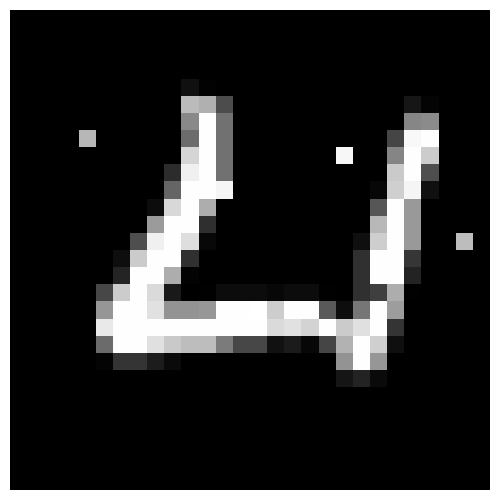

In [34]:
plot_figure(samples_10x2_pgd[33], cmap='gray')

#### Carlini and Wagner L_2 Attack


In [11]:
from art.attacks.evasion import CarliniL2Method

In [73]:
CnWAttack = CarliniL2Method(art_model, binary_search_steps=10, max_iter=20, verbose=True)
num_samples = 1000
CnW_samples = CnWAttack.generate(x_test[:num_samples])

C&W L_2:   0%|          | 0/1000 [00:00<?, ?it/s]

In [75]:
print(model.evaluate(CnW_samples, y_test[:num_samples]))
print(normal_model.evaluate(CnW_samples, y_test[:num_samples]))
print(pgd_model.evaluate(CnW_samples, y_test[:num_samples]))

[0.9552703280448913, 0.037]
[0.4617716794013977, 0.838]
[0.38078906035423277, 0.874]


In [78]:
np.save(output_path + model_name + '-CnW-samples', CnW_samples)

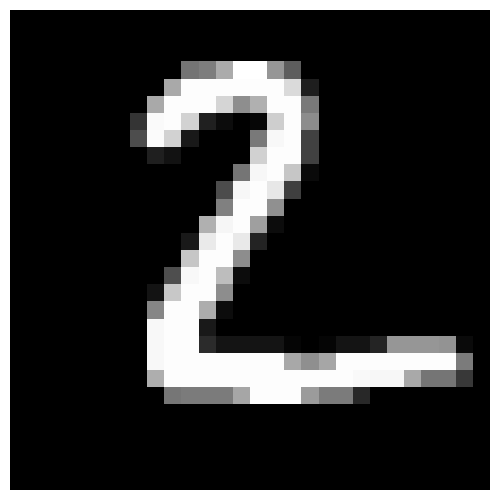

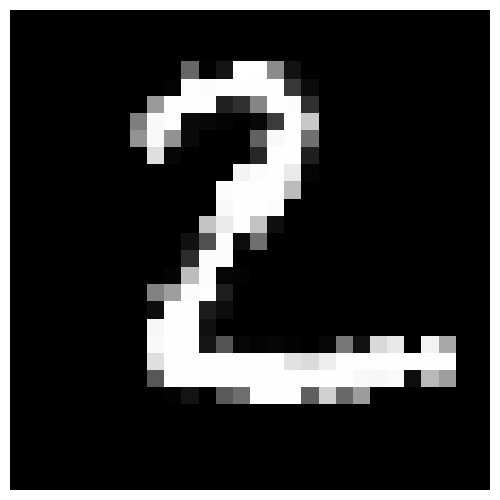

In [77]:
index = 1
plot_figure(x_test[index], cmap='gray')
plot_figure(CnW_samples[index], cmap='gray')
# plot_figure(abs(x_test[index] - CnW_samples[index]), cmap='gray')

### GTSRB

In [ ]:
import pickle
from keras.utils.np_utils import to_categorical

input_path = 'drive/MyDrive/CURIS/VeriX/train_networks/gtsrb.pickle'
with open(input_path, 'rb') as handle:
    gtsrb = pickle.load(handle)

x_train, y_train, x_valid, y_valid, x_test, y_test = gtsrb.values()
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [ ]:
# model_name = 'mnist-30x2-normal'
model_name = 'gtsrb-30x2-normal'
model = keras.models.load_model(network_path + model_name + '.h5')

In [ ]:
art_model = KerasClassifier(model, clip_values=(0, 1))
pgd_attack = ProjectedGradientDescent(art_model, eps=0.05, eps_step=0.01, max_iter=15, verbose=False)
adv_samples = pgd_attack.generate(x_test, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


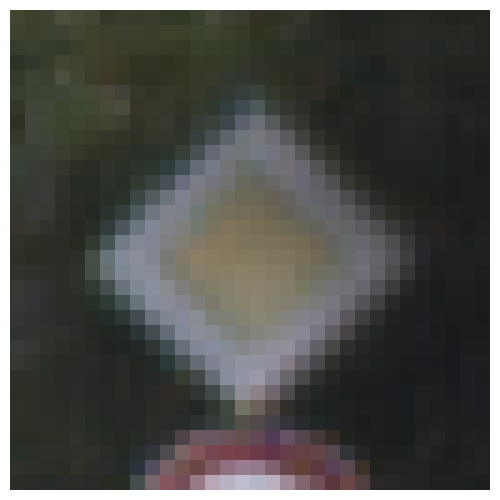

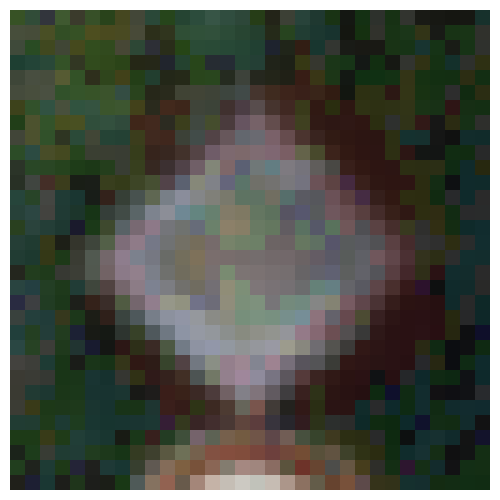

In [ ]:
index = 3
plot_figure(x_test[index])
plot_figure(adv_samples[index])

In [ ]:
normal = keras.models.load_model(network_path + 'gtsrb-100x2-normal.h5')
pgd = keras.models.load_model(network_path + 'gtsrb-100x2-pgd.h5')

In [ ]:
normal.evaluate(adv_samples, y_test)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


[10.772150755517277, 0.23209876]

In [ ]:
pgd.evaluate(adv_samples, y_test)

[3.26625607808431, 0.38688272]